In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.special as special
import scipy.stats as spstats

We start with the full 2-dimensional Gaussian PDF (lifted from wikipedia):

$$f(x,y) = \frac{1}{2 \pi \sigma_X \sigma_Y \sqrt{1-\rho^2}} e^{-\frac{1}{2(1-\rho^2)} \left[ (\frac{x - \mu_X}{\sigma_X})^2 + \frac{y - \mu_Y}{\sigma_Y})^2 - 2 \rho (\frac{x - \mu_X}{\sigma_X}) (\frac{y - \mu_Y}{\sigma_Y}) \right]}$$

For our purposes, we're only really concerned with ellipses, and the orientation of the ellipse doesn't particularly matter for now, so let's set $\rho = 0$ and define $\sigma_Y = 1$, while we adjust the means $\mu_X, \mu_Y$ later accordingly. We then get the much simpler:

$$f(x,y) = \frac{1}{2 \pi \sigma_X} e^{-\frac{1}{2} \left[ (\frac{x - \mu_X}{\sigma_X})^2 + \frac{y - \mu_Y}{1})^2 \right] }$$

We now just need to adjust $\sigma_X$ to be our relative stretch of the ellipse.

Let's start with the zero-mean example of a circular distribution i.e. $\sigma_X = 1, \mu_X = \mu_Y = 0$:

$$f(x,y) = \frac{1}{2 \pi} e^{-\frac{1}{2} \left[ x^2 + y^2 \right]} $$

There's no indefinite integral for Gaussians, so we can only use the error function given by

$$ erf(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt $$

which is the probability of obtaining a random variable in the range $[-x,x]$ for a zero-mean standard deviation of (**IMPORTANT**) $\frac{1}{\sqrt{2}}$. Explicitly, we convert the distribution via

$$\begin{align}
f(x,y) &= \frac{1}{2 \pi} e^{-\frac{1}{2} \left[ x^2 + y^2 \right]} \\
&= \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} x^2} \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} y^2} \\
\end{align}
$$

The two terms are independent and can be integrated separately (and are identical anyway) so we just integrate over the desired limits $-a, a$ by defining our dummy variable $t = \frac{x}{\sqrt{2}}, dx = \sqrt{2} dt$ like so:

$$\begin{align}
\frac{1}{\sqrt{2\pi}} \int_{-a}^{a}  e^{-\frac{1}{2} x^2} &= \frac{2}{\sqrt{2 \pi}} \int_{0}^{a} e^{-\frac{1}{2} x^2} dx\\
&= \frac{2}{\sqrt{\pi}} \int_{0}^{a/\sqrt{2}} e^{-t^2} dt\\
&= erf\left(a/\sqrt{2}\right)
\end{align}
$$

This form results in the standard 68, 95, 99.7 rule as demonstrated here:

In [10]:
print(special.erf(1/np.sqrt(2)))
print(special.erf(2/np.sqrt(2)))
print(special.erf(3/np.sqrt(2)))

0.6826894921370859
0.9544997361036416
0.9973002039367398


But more importantly, for 2-D and above the product of the two $erf$ functions must be taken into account, which results in the equivalent of the $1,2,3 \sigma$ rule becoming:

In [11]:
print(special.erf(1/np.sqrt(2))**2)
print(special.erf(2/np.sqrt(2))**2)
print(special.erf(3/np.sqrt(2))**2)

0.4660649426743922
0.9110697462219214
0.9946076967722628


But wait! What we did here is an integral over a **SQUARE** with limits $[-a,a], [-a,a]$. What we're most likely concerned with is a smooth circular integral that stretches $c = 1 \sigma$ in all directions (in the circular case), as this would *respect* the evolution of the probability distribution. To do this we simply integrate using the conditional limits by defining the **POLAR** limits and integrating via polar coordinates like so, $r^2 = x^2 + y^2$:

$$ \begin{align}
\frac{1}{2\pi} \int_{0}^{2\pi} \int_{0}^{c} e^{-\frac{1}{2} r^2} r dr d\theta &= \frac{1}{2\pi}  \int_{0}^{2\pi} \left[ \int_{0}^{c} r e^{-\frac{1}{2} r^2}  dr \right] d\theta \\
&= \frac{1}{2\pi}  \int_{0}^{2\pi} \left[ \left(1 -e^{ -\frac{1}{2} c^2} \right) \right] d\theta \\
&= 1 -e^{ -\frac{1}{2} c^2}
\end{align}
$$

The equivalent of the $1,2,3 \sigma$ rule is then:

In [22]:
def circularProbability(c):
    return (1-np.exp(-0.5*c**2))

print(circularProbability(1))
print(circularProbability(2))
print(circularProbability(3))

0.3934693402873666
0.8646647167633873
0.9888910034617577


We can verify this via simulation, counting everything within multiple sigmas..

0.39264
0.8637
0.98877


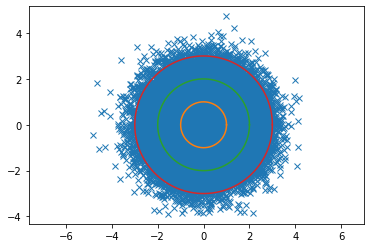

In [32]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance

x, y = np.random.multivariate_normal(mean, cov, 100000).T

theta = np.arange(0,2*np.pi+0.001/2,0.001)
circx = np.cos(theta)
circy = np.sin(theta)

plt.figure()
plt.plot(x, y, 'x')
plt.plot(circx,circy)
plt.plot(2*circx,2*circy)
plt.plot(3*circx,3*circy)
plt.axis('equal')

xy = np.vstack((x,y)).T
xynorm = np.linalg.norm(xy, axis=1)
print(len(np.argwhere(xynorm <= 1)) / len(xynorm))
print(len(np.argwhere(xynorm <= 2)) / len(xynorm))
print(len(np.argwhere(xynorm <= 3)) / len(xynorm))

The most straightforward way to extend from circular to elliptical distributions and see that the same rules hold - that is, that drawing an ellipse which matches the $n \sigma$ on both the major and minor axes will also result in the same percentages - is to simply construct a linear transform matrix which shapes the ellipse back to the circle.